In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import torch 
import torch.nn as nn
import torch.optim as optim

In [56]:
df = yf.download('AAPL', start='2020-01-01', end='2025-01-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.796021,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.088295,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.662697,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.320992,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.484337,132079200


In [57]:
len(df)

1258

In [58]:
df['next_close'] = df['Adj Close'].shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,next_close
Date,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.796021,135480400,72.088295
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.088295,146322800,72.662697
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.662697,118387200,72.320992
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.320992,108872000,73.484337
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.484337,132079200,75.045235


In [59]:
# 0 if the price goes down, 1 if the price goes up
df['target'] = 0
df.loc[df['next_close'] > df['Adj Close'], 'target'] = 1
df.head()

,Open,High,Low,Close,Adj Close,Volume,next_close,target
Date,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.796021,135480400,72.088295,0
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.088295,146322800,72.662697,1
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.662697,118387200,72.320992,0
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.320992,108872000,73.484337,1
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.484337,132079200,75.045235,1


In [60]:
X = df[['Volume', 'Adj Close']].values
y = df['target'].values

In [61]:
#  split the data into training and testing sets
split = int(0.7 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [62]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()

In [63]:
X_train.shape, y_train.shape

(torch.Size([880, 2]), torch.Size([880]))

In [64]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [65]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [72]:
epochs = 1000
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    # print(y_pred.shape, y_train.shape)
    loss = criterion(y_pred, y_train) 
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Epoch: {i} Loss: {loss.item()}')


Epoch: 0 Loss: 716.9882202148438
Epoch: 100 Loss: 25187.171875
Epoch: 200 Loss: 11015.111328125
Epoch: 300 Loss: 12024.7158203125
Epoch: 400 Loss: 14883.2373046875
Epoch: 500 Loss: 21024.654296875
Epoch: 600 Loss: 21157.88671875
Epoch: 700 Loss: 11124.552734375
Epoch: 800 Loss: 18976.7890625
Epoch: 900 Loss: 5081.451171875


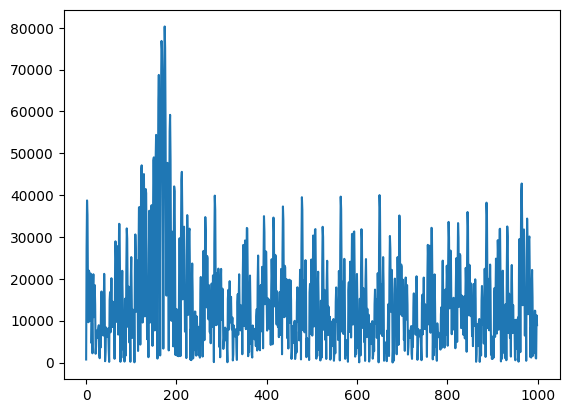

In [73]:
plt.plot(range(epochs), losses)

In [74]:
with torch.no_grad():
    y_val = model(X_test)
    correct = (torch.argmax(y_val, axis=1) == y_test).float()
    accuracy = correct.sum() / len(correct)

accuracy.item()

0.5582010746002197

In [88]:
# now ill give 10 days data to the model and see if it can predict the next day price
X = []
y = []
n = len(df)
for i in range(9,n):
    X.append(df.iloc[i-9:i][['Volume', 'Adj Close']].values)
    y.append(df.iloc[i]['target'])


In [89]:
X[0], y[0]

(array([[1.35480400e+08, 7.27960205e+01],
        [1.46322800e+08, 7.20882950e+01],
        [1.18387200e+08, 7.26626968e+01],
        [1.08872000e+08, 7.23209915e+01],
        [1.32079200e+08, 7.34843369e+01],
        [1.70108400e+08, 7.50452347e+01],
        [1.40644800e+08, 7.52148972e+01],
        [1.21532000e+08, 7.68217926e+01],
        [1.61954400e+08, 7.57844238e+01]]),
 1.0)

In [90]:
# train test split
split = int(0.7 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [91]:
# convert to tensor
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()

In [92]:
X_train[0]

tensor([[1.3548e+08, 7.2796e+01],
        [1.4632e+08, 7.2088e+01],
        [1.1839e+08, 7.2663e+01],
        [1.0887e+08, 7.2321e+01],
        [1.3208e+08, 7.3484e+01],
        [1.7011e+08, 7.5045e+01],
        [1.4064e+08, 7.5215e+01],
        [1.2153e+08, 7.6822e+01],
        [1.6195e+08, 7.5784e+01]])

In [94]:
# flatten the data
X_train = X_train.view(-1, 9*2)
X_test = X_test.view(-1, 9*2)

In [95]:
X_train[0]

tensor([1.3548e+08, 7.2796e+01, 1.4632e+08, 7.2088e+01, 1.1839e+08, 7.2663e+01,
        1.0887e+08, 7.2321e+01, 1.3208e+08, 7.3484e+01, 1.7011e+08, 7.5045e+01,
        1.4064e+08, 7.5215e+01, 1.2153e+08, 7.6822e+01, 1.6195e+08, 7.5784e+01])

In [97]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(18, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    

In [98]:
model = Model() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [102]:
losses = []
for i in range(epochs):
    y_pred = model(X_train)
    # print(y_pred.shape, y_train.shape)

    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Epoch: {i} Loss: {loss.item()}')

Epoch: 0 Loss: 3077.23876953125
Epoch: 100 Loss: 2418.668212890625
Epoch: 200 Loss: 2871.312744140625
Epoch: 300 Loss: 1985.5767822265625
Epoch: 400 Loss: 1899.52001953125
Epoch: 500 Loss: 2760.01171875
Epoch: 600 Loss: 2326.72802734375
Epoch: 700 Loss: 1687.9765625
Epoch: 800 Loss: 1773.2584228515625
Epoch: 900 Loss: 1612.4556884765625


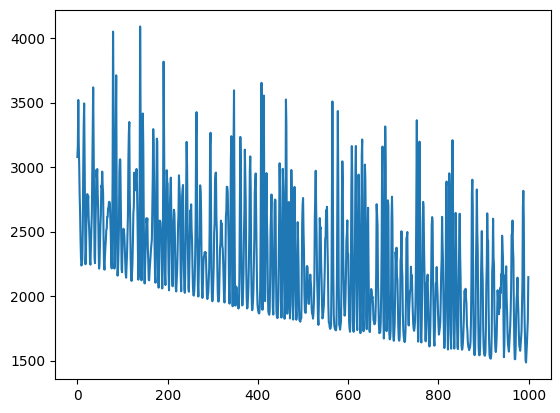

In [103]:
# plot the loss
plt.plot(range(epochs), losses)

In [104]:
# calculate the accuracy
with torch.no_grad():
    y_val = model(X_test)
    correct = (torch.argmax(y_val, axis=1) == y_test).float()
    accuracy = correct.sum() / len(correct)

In [105]:
accuracy.item()

0.5440000295639038

Similar result ANN can't comprehend sequential data